# <center> Déneiger Montréal

Le but de ce projet est de pouvoir déneiger Montréal avec le plus faible coûts possible.
    
## Partie 1: Étude cas théorique

Nous avons pour but de déneiger Montréal avec le plus faible coûts possible. Pour cela, nous avons à disposition un drone, 2200 appareils ainsi que 3000 employés.
    
Pour ce faire, nous allons découper notre problème en différentes parties:
- Récupérer le graphe de Montréal
- Rendre le graphe eulérien
- Trouver le plus court chemin pour le parcours du drone dans un graphe non-orienté
- Construire un sous-graphe avec seulement les rues enneigés et ajouter des arrêtes pour les rues enneigés et isolés (si toutes les rues ne sont pas enneigés)
- Découper le sous-graphes en fonctions du nombre de déneigeuses utilisés
- Trouver le plus court chemin pour chaque déneigeuse dans un graphe orienté
    
### Récupération du graph de Montréal

In [83]:
import osmnx as ox
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import itertools

In [66]:
%%time
G = ox.graph_from_place('Paris, France', network_type='drive')

CPU times: user 28.2 s, sys: 2.29 s, total: 30.5 s
Wall time: 41.2 s


In [24]:
%%time 
nodes = list(G.nodes)
edges = list(G.edges(data=True))

print(nodes)
print(edges)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Comme nous pouvons le constater, le graphe de Montréal est un petit peu trop grand. Ainsi nous utiliserons un graphe d'un quartier de Montréal pour tester. Nous pouvons également utiliser d'autres villes qui sont plus petites que Montréal.

In [30]:
%%time 
G = ox.graph_from_place('Griffintown, Montréal', network_type='drive')
nodes = list(G.nodes)
edges = list(G.edges(data=True))

edges_list = []
for (x, y, info) in edges:
    edges_list.append((nodes.index(x), nodes.index(y), info["length"]))


CPU times: user 1.66 s, sys: 74.5 ms, total: 1.73 s
Wall time: 1.93 s


### Rendre le graphe eulerien

In [38]:
def find_combination_odd_nodes(nodes):
    res = []
    for x in nodes:
        for y in nodes:
            if x != y and (x, y) not in res and (y, x) not in res:
                res.append((x, y))
    return res


def find_edge(edge_list, x, y):
    res = None
    for (a, b, w) in edge_list:
        if (a == x and b == y) or (a == y and b == x):
            res = (a, b, w)
    return res


def make_eulerian(num_vertices, edge_list, odd_vert_list):
    list_comb = find_combination_odd_nodes(odd_vert_list)
    reslist = []
    for (a, b) in list_comb:
        d = [a, b]
        d.extend(dijkstra(num_vertices, edge_list, a, b))
        reslist.append(tuple(d))

    new_edge_list = edge_list.copy()

    # sort by the cost
    reslist.sort(key=lambda tup: tup[2])

    while reslist:
        i = 0
        len_reslist = len(reslist[0][3]) - 1

        # append new edges (duplicating edge)
        while i < len_reslist:
            (a, b) = (reslist[0][3][i], reslist[0][3][i + 1])
            new_edge_list.append(find_edge(edge_list, a, b))
            i += 1

        # remove all tuple with x and y from reslist[0]
        reslist = [ elm for elm in reslist 
                   if reslist[0][0] not in elm[0:2] and reslist[0][1] not in elm[0:2]]
    return new_edge_list


In [67]:
def adjacent(n, edges):
    res = [[] for i in range(n)]
    for (x, y, w) in edges:
        res[x].append((y, w))
        res[y].append((x, w))
    return res


def dijkstra(n, edges, src, dst):
    if n == 0 or edges == []:
        return math.inf

    if src == dst:
        return 0

    adj = adjacent(n, edges)

    parents = [-1] * n
    dist = [math.inf] * n
    visit = [False] * n

    dist[src] = 0
    q = [src]

    while q:
        x = q.pop(0)
        for y, w in adj[x]:
            if dist[y] > dist[x] + w:
                dist[y] = dist[x] + w
                parents[y] = x

            if not visit[y]:
                visit[y] = True
                q.append(y)

    i = dst
    res = []

    while parents[i] != -1:
        res.insert(0, i)
        i = parents[i]

    res.insert(0, i)

    return (dist[dst], res)


# def floyd_warshall(n, edges):
#     m = [[math.inf for i in range(n)] for j in range(n)]
#     next = [[-1 for i in range(n)] for j in range(n)]

#     for (i, j, w) in edges:
#         m[i][j] = w
#         next[i][j] = j

#     for k in range(n):
#         for i in range(n):
#             for j in range(n):
#                 if i == j:
#                     m[i][j] = 0
#                     next[i][j] = i

#                 elif m[i][j] > m[i][k] + m[k][j]:
#                     m[i][j] = m[i][k] + m[k][j]
#                     next[i][j] = next[i][k]
#     return m, next


def find_path(u, v, next):
    if next[u][v] == -1:
        return []

    res = [u]
    while u != v:
        u = next[u][v]
        res.append(u)

    return res


### Trouver le plus court chemin

In [43]:
def find_eulerian_cycle(n, edges):
    if n == 0 or edges == []:
        return []

    adj = [[] for x in range(n)]

    for (x, y, w) in edges:
        adj[x].append(y)
        adj[y].append(x)

    edges_count = dict()
    for i in range(n):
        edges_count[i] = len(adj[i])

    curr = [0]
    res = []
    tmp_curr = 0

    while len(curr):
        if edges_count[tmp_curr]:
            curr.append(tmp_curr)
            next = adj[tmp_curr].pop()
            adj[next].remove(tmp_curr)

            edges_count[tmp_curr] -= 1
            edges_count[next] -= 1
            tmp_curr = next
        else:
            res.append(tmp_curr)
            tmp_curr = curr.pop()

    return res[::-1]

In [44]:
def solve(num_vertices, edge_list):
    odd_vert_list = odd_vertices(num_vertices, edge_list)
    
    if len(odd_vert_list) == 0:
        return find_eulerian_cycle(num_vertices, edge_list)

    new_edge_list = make_eulerian(num_vertices, edge_list, odd_vert_list)

    return find_eulerian_cycle(num_vertices, new_edge_list)

In [89]:
solve(len(nodes), edges_list)
# nx.draw(G)
# plt.show()

(86,
 [(0, 55),
  (55, 56),
  (56, 10),
  (10, 56),
  (56, 9),
  (9, 67),
  (67, 75),
  (75, 74),
  (74, 54),
  (54, 67),
  (67, 9),
  (9, 8),
  (8, 55),
  (55, 8),
  (8, 54),
  (54, 74),
  (74, 53),
  (53, 73),
  (73, 53),
  (53, 65),
  (65, 52),
  (52, 65),
  (65, 75),
  (75, 17),
  (17, 42),
  (42, 32),
  (32, 31),
  (31, 42),
  (42, 32),
  (32, 33),
  (33, 16),
  (16, 33),
  (33, 34),
  (34, 15),
  (15, 14),
  (14, 13),
  (13, 12),
  (12, 47),
  (47, 11),
  (11, 58),
  (58, 76),
  (76, 58),
  (58, 39),
  (39, 72),
  (72, 39),
  (39, 77),
  (77, 76),
  (76, 70),
  (70, 82),
  (82, 70),
  (70, 46),
  (46, 11),
  (11, 47),
  (47, 38),
  (38, 37),
  (37, 12),
  (12, 13),
  (13, 36),
  (36, 6),
  (6, 83),
  (83, 48),
  (48, 83),
  (83, 51),
  (51, 50),
  (50, 80),
  (80, 63),
  (63, 80),
  (80, 5),
  (5, 51),
  (51, 5),
  (5, 81),
  (81, 4),
  (4, 81),
  (81, 34),
  (34, 35),
  (35, 36),
  (36, 37),
  (37, 7),
  (7, 48),
  (48, 71),
  (71, 78),
  (78, 71),
  (71, 49),
  (49, 45),
  (45,

Dans cette partie, nous avons utilisé le drone. Ainsi, nous avons utilisé un graphe non orienté et déterminé le chemin eulerien le plus court chemin.

### Découpage de Montréal

Pour le cas théorique, nous n'arrivons pas à trouver une solution afin de découper Montréal.

## Cas Pratique

Dans le cas pratique, nous allons découper Montréal par quartier. Ainsi on récuperera tout simplement chaque quartier auquel nous appliquerons le problème du postier chinois orienté.
On utilise un graphe orienté car les dénegeuse ne passent que une seule fois dans les rues pour les déneiger et qu'il y a un sens dans les rues même si les déneigeuse ne passent que une seule fois dans les rues à double sens.

### Problème du postier chinois orienté

In [85]:
def solvePractical(num_vertices, edge_list):
    G = nx.Graph()
    for u, v, w in edge_list:
        G.add_edge(u, v, weight=w)

    if G.is_directed() and not nx.is_weakly_connected(G):
        raise nx.NetworkXError("G is not connected")
        
    if not G.is_directed() and not nx.is_connected(G):
        raise nx.NetworkXError("G is not connected")

    circuit = []
    
    if nx.is_eulerian(G):
        circuit = [i for i in nx.eulerian_circuit(G)]
    else:
        G = nx.algorithms.euler.eulerize(G)
        circuit = [i for i in nx.eulerian_circuit(G)]
    
    print(G)
    nx.draw(G)
    plt.show()
    return num_vertices, circuit

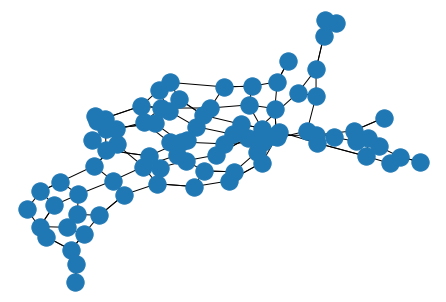

CPU times: user 273 ms, sys: 11.8 ms, total: 285 ms
Wall time: 310 ms


(188,
 [(0, 55),
  (55, 56),
  (56, 10),
  (10, 56),
  (56, 9),
  (9, 67),
  (67, 75),
  (75, 74),
  (74, 54),
  (54, 67),
  (67, 9),
  (9, 8),
  (8, 55),
  (55, 8),
  (8, 54),
  (54, 74),
  (74, 53),
  (53, 73),
  (73, 53),
  (53, 65),
  (65, 52),
  (52, 65),
  (65, 75),
  (75, 17),
  (17, 42),
  (42, 32),
  (32, 31),
  (31, 42),
  (42, 32),
  (32, 33),
  (33, 16),
  (16, 33),
  (33, 34),
  (34, 15),
  (15, 14),
  (14, 13),
  (13, 12),
  (12, 47),
  (47, 11),
  (11, 58),
  (58, 76),
  (76, 58),
  (58, 39),
  (39, 72),
  (72, 39),
  (39, 77),
  (77, 76),
  (76, 70),
  (70, 82),
  (82, 70),
  (70, 46),
  (46, 11),
  (11, 47),
  (47, 38),
  (38, 37),
  (37, 12),
  (12, 13),
  (13, 36),
  (36, 6),
  (6, 83),
  (83, 48),
  (48, 83),
  (83, 51),
  (51, 50),
  (50, 80),
  (80, 63),
  (63, 80),
  (80, 5),
  (5, 51),
  (51, 5),
  (5, 81),
  (81, 4),
  (4, 81),
  (81, 34),
  (34, 35),
  (35, 36),
  (36, 37),
  (37, 7),
  (7, 48),
  (48, 71),
  (71, 78),
  (78, 71),
  (71, 49),
  (49, 45),
  (45

In [86]:
%%time
solvePractical(len(edges), edges_list)